In [1]:
import torch
import os
import shutil
import argparse
from tqdm import tqdm
import time
from collections import defaultdict
import pandas as pd
from im2mesh import config
from im2mesh.checkpoints import CheckpointIO
from im2mesh.utils.io import export_pointcloud
from im2mesh.utils.visualize import visualize_data
from im2mesh.utils.voxels import VoxelGrid
import matplotlib.pyplot as plt
import numpy as np

/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using pose in the model


/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jw/anaconda3/envs/mesh_funcspace/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


out/img/onet_convnext_fp_max_pose/model_best.pt
=> Loading checkpoint from local file...
Total number of parameters: 86356969


 16%|█▌        | 7/44 [00:04<00:24,  1.52it/s]


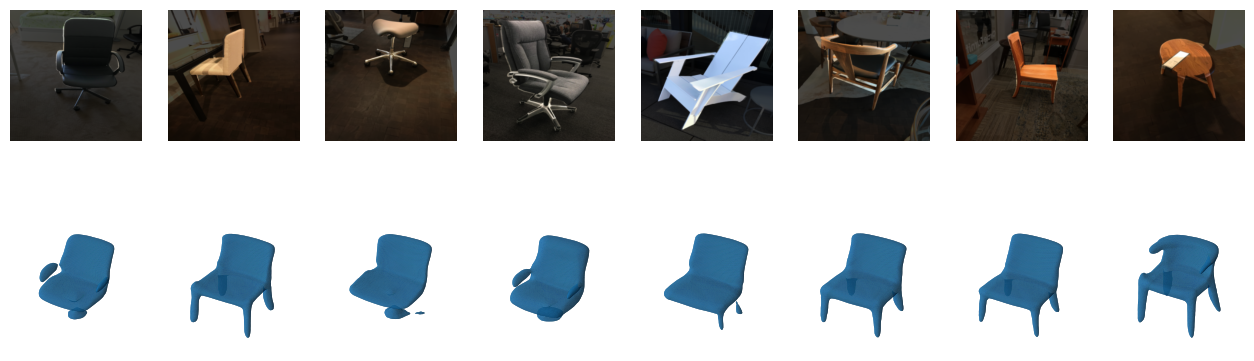

In [3]:

# cfg = config.load_config("configs/img/onet_original.yaml")
# cfg = config.load_config("configs/img/onet_convnext.yaml")
cfg = config.load_config("configs/img/onet_convnext_fp_max_pose.yaml")
device = torch.device("cuda")

out_dir = cfg['training']['out_dir']

batch_size = cfg['generation']['batch_size']
input_type = cfg['data']['input_type']
vis_n_outputs = cfg['generation']['vis_n_outputs']
if vis_n_outputs is None:
    vis_n_outputs = -1

# Dataset
dataset = config.get_dataset('test', cfg, return_idx=True)

# Model
with_pose = 'pose_dim' in cfg['data']
if with_pose:
    print('Using pose in the model')
    model = config.get_model_with_pose(cfg, device=device, dataset=dataset)
else:
    model = config.get_model(cfg, device=device, dataset=dataset)

checkpoint_io = CheckpointIO(out_dir, model=model)
checkpoint_io.load(cfg['test']['model_file'])

# Generator
generator = config.get_generator(model, cfg, device=device)

# Determine what to generate
generate_mesh = cfg['generation']['generate_mesh']

if generate_mesh and not hasattr(generator, 'generate_mesh'):
    generate_mesh = False
    print('Warning: generator does not support mesh generation.')


# Loader
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, num_workers=0, shuffle=False)


# Generate
model.eval()

nparameters = sum(p.numel() for p in model.parameters())
print('Total number of parameters: %d' % nparameters)

# Count how many models already created
model_counter = defaultdict(int)

fig = plt.figure(figsize=(20, 5))

for it, data in enumerate(tqdm(test_loader)):
    # Calculate subplot index
    row_idx = it // 10
    col_idx = it % 10

    # Get index etc.
    idx = data['idx'].item()

    try:
        model_dict = dataset.get_model_dict(idx)
    except AttributeError:
        model_dict = {'model': str(idx), 'category': 'n/a'}
    
    modelname = model_dict['model']

    if generate_mesh:
        out = generator.generate_mesh(data, with_pose)

        # Get statistics
        mesh, stats_dict = out

        # Calculate subplot index
        row_idx = it // 10
        col_idx = it % 10

        # Plot input image
        ax = fig.add_subplot(2, 10, col_idx + 1)
        ax.axis('off')
        inputs = data['inputs']
        # apply mask semi-transparently
        inputs *= 0.3 + 0.7*data['inputs.mask']
        ax.imshow(inputs.squeeze(0).cpu().permute(1, 2, 0))

        # Plot mesh
        ax = fig.add_subplot(2, 10, col_idx + 11, projection='3d')
        ax.axis('off')
        # Define a rotation matrix for 180 degrees around the y-axis
        theta = np.radians(180)  # Convert degrees to radians
        c, s = np.cos(theta), np.sin(theta)
        R_y = np.array([
            [c, 0, s],
            [0, 1, 0],
            [-s, 0, c]
        ])

        # Apply the rotation to the vertices
        rotated_vertices = np.dot(mesh.vertices, R_y.T)  # Transpose to get correct orientation

        phi = np.radians(90)  # Convert degrees to radians
        c, s = np.cos(phi), np.sin(phi)
        R_x = np.array([
            [1, 0, 0],
            [0, c, -s],
            [0, s, c]
        ])

        # Apply the rotation to the already rotated vertices
        rotated_vertices = np.dot(rotated_vertices, R_x.T)  

        ax.plot_trisurf(rotated_vertices[:, 0], rotated_vertices[:, 1], rotated_vertices[:, 2], triangles=mesh.faces)

        # Set uniform scaling
        ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio

    # Break after 10 data samples
    if it == 8-1:
        break

plt.show()


In [4]:
base = torch.load('out/img.chair.16/onet_original/model_best.pt')['loss_val_best']
ours = torch.load('out/img/onet_convnext_fp_max_pose/model_best.pt')['loss_val_best']

print(f"{base:.4f} {ours:.4f}")
print(f"{(ours / base - 1) * 100:.1f}%")

0.4041 0.3838
-5.0%


In [ ]:
https://wormhole.app/po013#_-kmFIrdjkDZ1fLYuDlhsw